In [44]:
import os
from shutil import rmtree
import math
import random
from termcolor import colored
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from prepare_data import get_data
from sklearn.model_selection import train_test_split
from constant import CANDLES_HISTORY
from add_indicators import get_column_indicators

In [45]:
if os.path.exists("resources/model"):
    rmtree("resources/model")
if os.path.exists("resources/parameters"):
    rmtree("resources/parameters")
if os.path.exists("logs/fit"):
    rmtree("logs/fit")

In [46]:
def get_dataset(train_data):
    x_train = []
    for i in range(CANDLES_HISTORY, len(train_data)):
        x_train.append(train_data[i-CANDLES_HISTORY:i, :-1])
    return np.array(x_train)

In [54]:
def create_model(shape_examples, shape_features):
    print(colored('Generating LSTM model.', 'yellow'))
    print(colored(f'Shape {shape_examples}x{shape_features}', 'cyan'))

    model = Sequential()
    model.add(LSTM(
        units=50,
        return_sequences=True,
        input_shape=(shape_examples, shape_features)
    ))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model


In [48]:
try:
    df = pd.read_csv("resources/test.csv")
except FileNotFoundError:
    print(colored('Creating missing file.', 'red'))
    get_data()
    df = pd.read_csv("resources/test.csv")

df = df.iloc[48680:, :]
df.reset_index(inplace=True, drop=True)
indicators = list(filter(
    lambda x: x not in ["timestamp", "Zigzag"],
    get_column_indicators(df.columns)
))
df = df[["Close", "Open", "High", "Low"] + indicators + ["Zigzag"]]
df[(CANDLES_HISTORY - 5):(CANDLES_HISTORY + 5)]


,Close,Open,High,Low,RSI_20,STDEV_20,SMA_20,SMA_5,Zigzag
15,12087.29,12083.28,12089.03,12081.91,66.193172,49.219136,12018.5145,12082.808,0.0
16,12084.04,12087.41,12088.29,12082.67,65.311899,50.998872,12022.9260,12083.836,0.0
17,12089.04,12083.79,12092.54,12083.04,66.044010,52.013505,12028.3510,12085.388,1.0
18,12089.05,12089.29,12091.30,12084.55,66.045518,52.601900,12033.6015,12086.516,0.0
19,12083.31,12089.05,12089.05,12083.18,64.318847,48.159775,12041.0530,12086.546,0.0
20,12061.81,12083.43,12083.56,12061.81,58.308480,45.072177,12045.7830,12081.450,0.0
21,12062.10,12062.06,12071.35,12062.06,58.363722,41.249476,12050.5010,12077.062,0.0
22,12053.82,12063.85,12069.56,12051.32,56.128528,36.068309,12054.9190,12070.018,0.0
23,12055.94,12054.32,12062.37,12051.32,56.576733,31.872576,12058.5590,12063.396,0.0
24,12057.77,12056.44,12070.62,12049.57,56.976121,27.876893,12061.8080,12058.288,0.0


In [49]:
try:
    X = np.load('resources/parameters/X.npy')
    Y = np.load('resources/parameters/Y.npy')
    scaler = joblib.load("resources/parameters/scaler.save")
    print(colored('Loaded storaged data.', 'green'))
except FileNotFoundError:
    print(colored('Setting up parameters.', 'yellow'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    if not os.path.exists("resources/parameters"):
        os.makedirs("resources/parameters")

    joblib.dump(scaler, "resources/parameters/scaler.save")
    X = get_dataset(scaled_data)
    Y = np.array(scaled_data[CANDLES_HISTORY:len(scaled_data), -1])
    np.save("resources/parameters/X.npy", X)
    np.save("resources/parameters/Y.npy", Y)
    print(colored('Parameters saved succesfully.', 'green'))


Setting up parameters.
Parameters saved succesfully.


In [50]:
RANDOM_VALUE = random.randint(0, len(Y))
check_split_df = pd.DataFrame(X[CANDLES_HISTORY + RANDOM_VALUE])
check_split_df["prediction"] = Y[RANDOM_VALUE:CANDLES_HISTORY + RANDOM_VALUE]
check_split_df = scaler.inverse_transform(check_split_df.values)
check_split_df = pd.DataFrame(check_split_df)
print(RANDOM_VALUE)
print(check_split_df.loc[0].values)
print(df.loc[CANDLES_HISTORY + RANDOM_VALUE].values)

all(check_split_df.loc[0].values.round() == df.loc[CANDLES_HISTORY + RANDOM_VALUE].values.round())



15804
[16489.6       16482.11      16502.91      16476.72         60.4189641
    38.0087923 16429.2275    16469.492         0.       ]
[16489.6       16482.11      16502.91      16476.72         60.4189641
    38.0087923 16429.2275    16469.492         0.       ]


True

In [51]:
PERCENTAGE_DATA = 0

print(colored(f'X shape: {X.shape}', 'yellow'))
print(colored(f'Y shape: {Y.shape}', 'yellow'))

training_data_len = math.ceil(len(Y) * .80)
x_train = X[:training_data_len]
y_train = Y[:training_data_len]

zipped = list(zip(x_train, y_train))
random.shuffle(zipped)
zipped_len_train = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_train]
x_train, y_train = zip(*zipped)

x_train = np.array(x_train)
y_train = np.array(y_train)

print(colored(f'X_train shape: {x_train.shape}', 'blue'))
print(colored(f'Y_train shape: {y_train.shape}', 'blue'))

divition = training_data_len  # + (len(Y[training_data_len:]) / 5)
shrink = math.ceil(divition)
x_test = X[shrink:-1]
y_test = Y[shrink:-1]

zipped = list(zip(x_test, y_test))
random.shuffle(zipped)
zipped_len_test = math.ceil(len(zipped) - len(zipped) * PERCENTAGE_DATA)
zipped = zipped[:zipped_len_test]
x_test, y_test = zip(*zipped)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(colored(f'X_test shape: {x_test.shape}', 'cyan'))
print(colored(f'Y_test shape: {y_test.shape}', 'cyan'))
print(colored(f'Shrink: {shrink}', 'red'))


X shape: (22010, 20, 8)
Y shape: (22010,)
X_train shape: (17608, 20, 8)
Y_train shape: (17608,)
X_test shape: (4401, 20, 8)
Y_test shape: (4401,)
Shrink: 17608


In [52]:

def get_len(samples):
    return math.ceil(len(samples) * PERCENTAGE_DATA)


def compute_total():
    return (
        (y_test.shape[0] + get_len(Y[training_data_len:]))
        +
        (
            shrink - (
                y_train.shape[0] +
                get_len(Y[:training_data_len])
            )
        )
        +
        (y_train.shape[0] + get_len(Y[:training_data_len]))
    )


print('test + train:', colored(
    compute_total(),
    'green' if (compute_total()) else 'red'
))

test + train: 22009


In [55]:
try:
    model = load_model('resources/model/my_model_sequential.h5')
    print(colored('Model loaded successfully', 'green'))
except IOError:
    if not os.path.exists("resources/model"):
        os.makedirs("resources/model")
    print(colored('Training...', 'yellow'))
    model = create_model(X.shape[1], X.shape[-1])
    es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=100)
    checkpoint = ModelCheckpoint(
        'resources/model/best_model_checkpoint.h5',
        monitor='val_acc',
        mode='min',
        verbose=1,
        save_best_only=True
    )
    log_dir = "logs/fit"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        x_train, y_train, batch_size=64, epochs=1000,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint, tensorboard_callback, es]
    )

    model.save('resources/model/my_model_sequential.h5')
    hist_df = pd.DataFrame(history.history)
    with open('resources/model/history_sequential.csv', mode='w') as f:
        hist_df.to_csv(f)


Training...
Generating LSTM model.
Shape 20x8
Epoch 1/1000


ValueError: in user code:

    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 480, in update_state
        self.build(y_pred, y_true)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 393, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 526, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 526, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 545, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/metrics/__init__.py", line 182, in get
        return deserialize(str(identifier))
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/metrics/__init__.py", line 138, in deserialize
        return deserialize_keras_object(
    File "/home/ubuntu/Work/price_prediction/us100_prediction/env/lib/python3.8/site-packages/keras/utils/generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: val_acc. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


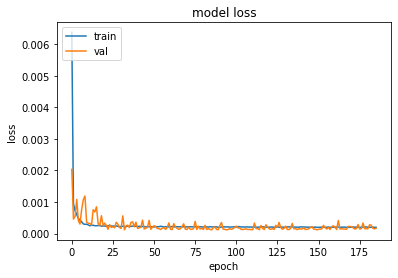

In [ ]:
history = pd.read_csv("resources/model/history_sequential.csv")
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
train_acc

5.395666812546551e-05

In [ ]:
index = 3
sample = np.array([x_test[index]])

y_sample = scaler.inverse_transform([[y_test[index]] * 5 + [y_test[index]]])
print(y_sample[0][-1])
prediction = model.predict(sample)[0][0]
data = scaler.inverse_transform([[prediction] * 5 + [prediction]])
print(data[0][-1])



13259.52
1/1 [==============================] - 0s 42ms/step
13349.548144509792
